# Daily Return Analysis and Trading Strategies

In [382]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt
import time
import itertools
import joblib

from jsonschema.exceptions import relevance
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier, LinearRegression
from courselib.models.nn import Sigmoid
from courselib.models.nn import MLP
from courselib.models.svm import BinaryKernelSVM
from courselib.models.svm import Kernel, RBFKernel, PolynomialKernel,LinearKernel
from courselib.utils.splits import train_test_split
from courselib.models.base import TrainableModel
from courselib.utils.metrics import binary_accuracy, mean_squared_error, mean_absolute_error,accuracy
from courselib.optimizers import GDOptimizer
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier
from courselib.utils.normalization import min_max
from courselib.models.glm import LogisticRegression
from courselib.models.base import TrainableModel
from courselib.utils.preprocessing import labels_encoding
from courselib.models.svm import LinearSVM
from courselib.models.svm import BinaryKernelSVM
from courselib.utils.metrics import cross_entropy
from courselib.utils.normalization import standardize
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif

In [383]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    df = pd.DataFrame(data)
    df.columns = df.columns.droplevel(1)
    return df



def compute_technical_indicators(data,amount,window):
    df = data.copy()

    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0).abs()
    avg_gain = up.ewm(window, adjust=False).mean()
    avg_loss = down.ewm(window, adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std

    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df['Daily_Return'] = df['Close'].pct_change()


    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()

    for i in range(amount):
        df[f'Lag_{i+1}'] = df['Daily_Return'].shift(i)

    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

def return_data(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Trend'] = df['Close'].rolling(window=5).mean().shift(-1) > df['Close']
    df['Target_01'] = np.where(df['Trend'], 1, 0)
    df['Target_-1'] = np.where(df['Trend'], 1, -1)
    df['Target_Sign'] = np.sign(df['Close'].shift(-1) - df['Close']).shift(-1)
    df['Target_Sign_01'] = np.where(df['Target_Sign'] > 0, 1, 0)
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test,df


In [384]:
df = fetch_data('SPY', '2015-01-01', '2025-12-31')

C:\Users\Micha\AppData\Local\Temp\ipykernel_34188\349399118.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


Kernel SVM


In [385]:
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, df = return_data(df, target_type='Target_Sign', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)
df

Price,Date,SMA_14,EMA_14,RSI_14,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Target_Sign,Close
19,2015-01-30,168.955163,169.083922,23.546595,172.828023,165.551788,-0.636616,-0.474055,-0.012575,0.010508,-0.012575,0.009244,-0.012824,0.359146,1.0,166.573746
20,2015-02-02,168.911616,169.024282,28.787117,172.510215,165.576455,-0.616102,-0.502465,0.012384,0.013018,0.012384,-0.012575,0.009244,0.242203,-1.0,168.636627
21,2015-02-03,169.076261,169.297750,34.475894,172.744014,165.603227,-0.398472,-0.481666,0.014461,0.013672,0.014461,0.012384,-0.012575,2.321747,1.0,171.075287
22,2015-02-04,169.267161,169.447904,33.705333,172.791602,165.909753,-0.275385,-0.440410,-0.003808,0.011650,-0.003808,0.014461,0.012384,0.818481,-1.0,170.423904
23,2015-02-05,169.690711,169.807423,37.648922,173.162809,165.856741,-0.038571,-0.360042,0.010095,0.011753,0.010095,-0.003808,0.014461,0.016724,-1.0,172.144302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2638,2025-07-01,604.268542,606.024189,70.675784,618.198816,585.416864,8.883796,7.934586,-0.000324,0.003381,-0.000324,0.004781,0.004968,16.746460,1.0,617.650024
2639,2025-07-02,605.758724,607.947632,72.221941,621.082710,585.144670,9.265255,8.200720,0.004533,0.002937,0.004533,-0.000324,0.004781,24.681213,-1.0,620.450012
2640,2025-07-03,607.427983,610.266618,74.716437,624.667921,584.676116,9.848618,8.530299,0.007881,0.002954,0.007881,0.004533,-0.000324,29.661011,-1.0,625.340027
2641,2025-07-07,609.245104,611.655068,68.441061,626.316802,585.965040,9.821694,8.788578,-0.007452,0.005988,-0.007452,0.007881,0.004533,26.399963,1.0,620.679993


In [386]:
rbf_svm = BinaryKernelSVM(kernel='rbf',sigma = 0.3)
metrics_history = rbf_svm.fit(X_train,Y_train)
binary_acc = binary_accuracy(rbf_svm(X_train), Y_train)

In [387]:
y_pred_test = rbf_svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)


Test Accuracy: 58.285714285714285


In [388]:
split_idx = int(round(train_frac * len(df)))
test_indices = df.index[split_idx:]

df['rbf_svm_pred'] = np.nan
df.loc[test_indices, 'rbf_svm_pred'] = y_pred_test
df['rbf_svm_pred'] = df['rbf_svm_pred'].shift(1)
df.dropna(inplace=True)

In [389]:
df['strategy_return'] = df['Daily_Return'] * df['rbf_svm_pred']
df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod()
df['cumulative_asset'] = (1 + df['Daily_Return']).cumprod()
print("strategy return is", df['cumulative_strategy'].iloc[-1])
print("asset return is", df['cumulative_asset'].iloc[-1])


strategy return is 1.4607902718012402
asset return is 1.493776855084634


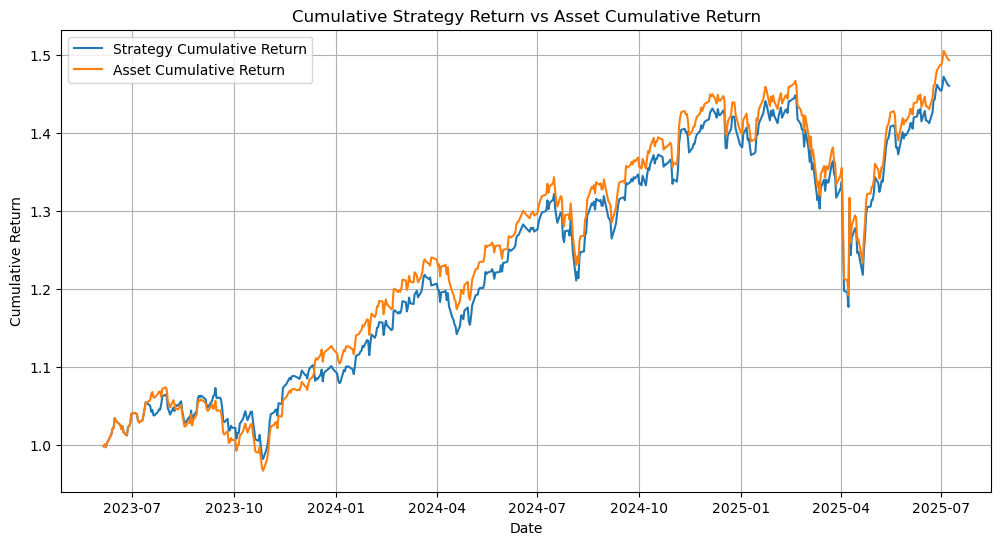

In [390]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(df['Date'], df['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Logistic Regression

In [391]:
df = fetch_data('SPY', '2015-01-01', '2025-12-31')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, df = return_data(df, target_type='Target_Sign_01', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)


C:\Users\Micha\AppData\Local\Temp\ipykernel_34188\349399118.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [392]:
w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true, class_labels=[0, 1]), 
                "loss": lambda y_pred, y_true: cross_entropy(y_pred, y_true)}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [393]:
y_pred_test = logistic_regression(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 58.0952380952381


In [394]:
split_idx = int(round(train_frac * len(df)))
test_indices = df.index[split_idx:]

df['logistic_pred'] = np.nan
df.loc[test_indices, 'logistic_pred'] = y_pred_test
df['logistic_pred'] = df['logistic_pred'].shift(1)
df.dropna(inplace=True)
df['logistic_pred'].replace(0, -1, inplace=True)

C:\Users\Micha\AppData\Local\Temp\ipykernel_34188\1364197977.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['logistic_pred'].replace(0, -1, inplace=True)


In [395]:
df['strategy_return'] = df['Daily_Return'] * df['logistic_pred']
df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod()
df['cumulative_asset'] = (1 + df['Daily_Return']).cumprod()
print("strategy return is", df['cumulative_strategy'].iloc[-1])
print("asset return is", df['cumulative_asset'].iloc[-1])


strategy return is 1.4603152996208566
asset return is 1.5065855773142203


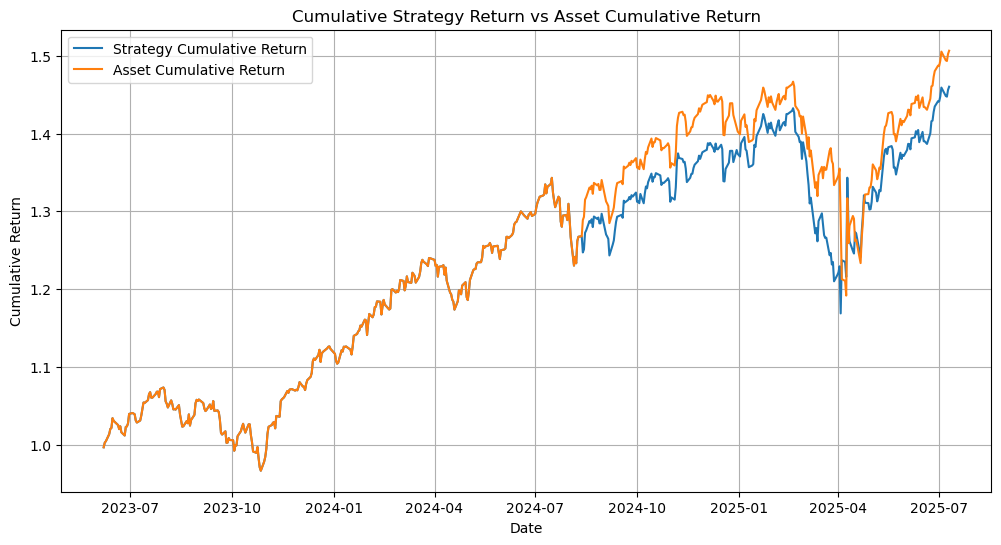

In [396]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(df['Date'], df['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [397]:
# Prepare data
X, Y, X_train, Y_train, X_test, Y_test, df= return_data(df, target_type='Target_01', train_frac=0.8, features='whole')
X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)

# Model setup
w = [0] * X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy_reg = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy_reg, 'MSE': mean_squared_error}

model_regression = LogisticRegression(w, b, optimizer)

# Train the model
metrics_history = model_regression.fit(
    X_train, Y_train,
    num_epochs=20000,
    batch_size=len(X_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)
joblib.dump((model_regression, metrics_history, X_test, Y_test, X, df), "regression_model_outputs.pkl")

['regression_model_outputs.pkl']

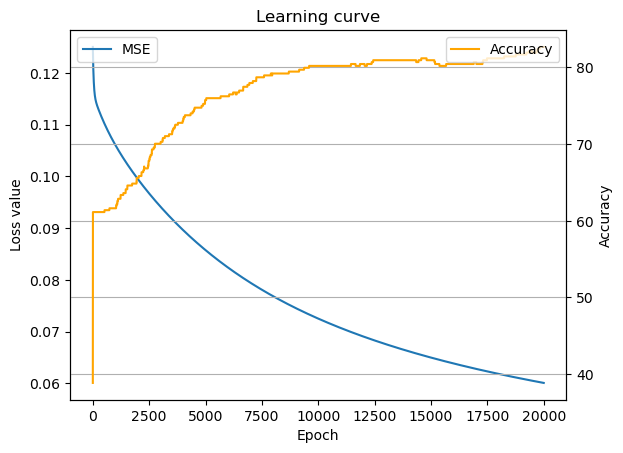

The final train accuracy: 82.67%
Test accuracy: 67.33%


In [398]:
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("regression_model_outputs.pkl")
# Plot learning curve
fig, ax = plt.subplots()
ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.title('Learning curve')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.show()

# Evaluation
print(f'The final train accuracy: {metrics_history["accuracy"][-1]:.2f}%')
print(f'Test accuracy: {accuracy_reg(model_regression.decision_function(X_test), Y_test):.2f}%')

In [399]:
# --- Rolling window accuracy plot (with real dates) ---
model_regression, metrics_history, X_test, Y_test, X_full, df = joblib.load("regression_model_outputs.pkl")
# Extract aligned dates from original df
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# Use same logic to align Date with test set
date_series = df_copy['Date'].iloc[-len(X):].values
split_idx = int(len(X) * 0.8)
test_dates = date_series[split_idx:]

# Predictions
Y_pred = model_regression(X_test)
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_test,
    'Predicted': Y_pred
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# Plot
plt.figure(figsize=(14, 4))
plt.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
plt.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
plt.title('Rolling Prediction Accuracy (Logistic Regression)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'Date'